In [2]:
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.layers import *
import keras_nlp
from keras_nlp.layers import *
from tensorflow.keras.models import Model

SEED = 42
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 256
EMBED_DIM = 128
INTERMEDIATE_DIM = 256

Using TensorFlow backend


In [3]:
data = pd.read_csv('C:/Users/slava/Desktop/PhishingML/venv/Scripts/phishing_email.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
data.sample(5)

,text_combined,label
12569,draft aep agreement another another incorporat...,0
81455,chase chasebankingcom fwd software upgrade sec...,1
43479,moises campos alimonomericavilabrianmpalmercom...,1
54916,june clifton juneferienwohnungriedelde excited...,1
3667,wild fuck pretty slutty mom amicable frying pa...,1


In [5]:
data_clean = data.copy()

In [6]:
data_missing_value = data_clean.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(data_clean))*100,2)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage


In [7]:
data_clean.duplicated().sum()

408

In [8]:
# % of duplicate data
print(str((data_clean.duplicated().sum() / len(data_clean)) * 100) + ' %')

0.49462939165434133 %


In [9]:
data_clean = data_clean.drop_duplicates()

In [10]:
data_clean.duplicated().sum()

0

In [11]:
%%time
# preprocessing functions
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\w+\s*', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions 
full_data = data.copy()
full_data['preprocessed_text_combined'] = data['text_combined'].apply(text_preprocessing).apply(drop_stopwords).apply(delete_one_characters)

CPU times: total: 24.9 s
Wall time: 24.9 s


In [12]:
# final dataframe
full_data.head()

,text_combined,label,preprocessed_text_combined
0,hpl nom may 25 2001 see attached file hplno 52...,0,hpl nom may see attached file hplno xls hplno xls
1,nom actual vols 24 th forwarded sabrae zajac h...,0,nom actual vols th forwarded sabrae zajac hou ...
2,enron actuals march 30 april 1 201 estimated a...,0,enron actuals march april estimated actuals ma...
3,hpl nom may 30 2001 see attached file hplno 53...,0,hpl nom may see attached file hplno xls hplno xls
4,hpl nom june 1 2001 see attached file hplno 60...,0,hpl nom june see attached file hplno xls hplno...


In [13]:
# train,validation and test splitting

train_val_data, test_data = train_test_split(full_data, test_size = 0.13, random_state = SEED, stratify = full_data['label'])
train_data, val_data = train_test_split(train_val_data, test_size = 0.15, random_state = SEED, stratify = train_val_data['label'])


train_data.reset_index(drop = True, inplace = True)
val_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

print('train samples :\t', train_data.shape[0])
print('val samples :\t', val_data.shape[0])
print('test samples :\t', test_data.shape[0])

train samples :	 60997
val samples :	 10765
test samples :	 10724


In [25]:
%%time
# Creating Vocabulary and Tokenizer

train_dataset_for_vocab = tf.data.Dataset.from_tensor_slices(train_data['preprocessed_text_combined'].values)
reserved_tokens = ["[PAD]", "[UNK]"]

# creating vocabulary
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(train_dataset_for_vocab, VOCAB_SIZE, reserved_tokens = reserved_tokens)

# creating tokenizer
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(vocabulary = vocab, lowercase = True, sequence_length = MAX_SEQUENCE_LENGTH)

CPU times: total: 39min 54s
Wall time: 39min 43s


In [26]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
import pickle
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [15]:
# Creating tf.data Pipeline

# a function for tf.data pipeline
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

In [16]:
# tf.datasets

test_loader = tf.data.Dataset.from_tensor_slices((test_data['preprocessed_text_combined'], test_data['label']))
test_dataset = (test_loader.map(format_dataset, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

In [17]:
# a function for calculating and plotting predictions 
def plot_prediction_results(y_true: np.array, y_pred : np.array) -> None:
    
    mse = mean_squared_error(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    clf = classification_report(y_true, y_pred, target_names = ['non-spam', 'spam'])
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels = ['non-spam', 'spam'],  xticks_rotation="vertical", values_format = '2g', colorbar = False)

In [18]:
%%time
# Creating pipeline
log_reg = make_pipeline(TfidfVectorizer(), LogisticRegression(C=5.0, max_iter = 200))
log_reg.fit(train_data['preprocessed_text_combined'].values, train_data['label'].values)

CPU times: total: 9.77 s
Wall time: 8.9 s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=5.0, max_iter=200))])

Mean Squared Error :	0.01175
Weighted F1 Score :	0.988
Accuracy Score :	98.825 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

    non-spam       0.99      0.99      0.99      5140
        spam       0.99      0.99      0.99      5584

    accuracy                           0.99     10724
   macro avg       0.99      0.99      0.99     10724
weighted avg       0.99      0.99      0.99     10724

----------------------------------------------------------------------

 Confusion Matrix: 



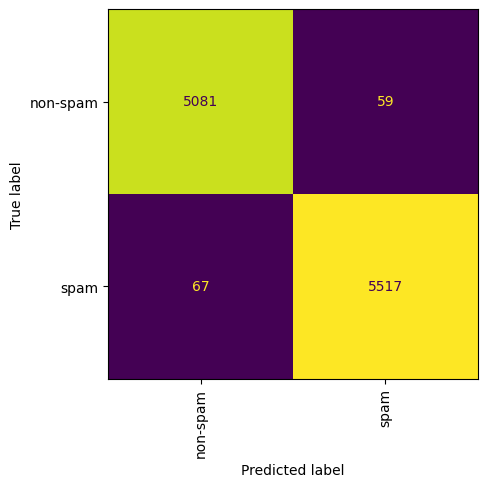

In [19]:
test_pred_log_reg = log_reg.predict(test_data['preprocessed_text_combined'])
plot_prediction_results(test_pred_log_reg, test_data['label'].values)

In [20]:
%%time
from sklearn.linear_model import SGDClassifier
clf = make_pipeline(TfidfVectorizer(), SGDClassifier(loss="hinge", penalty="l2", max_iter=15))
clf.fit(train_data['preprocessed_text_combined'].values, train_data['label'].values)

CPU times: total: 8 s
Wall time: 7.99 s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('sgdclassifier', SGDClassifier(max_iter=15))])

Mean Squared Error :	0.01651
Weighted F1 Score :	0.983
Accuracy Score :	98.349 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

    non-spam       0.98      0.99      0.98      5091
        spam       0.99      0.98      0.98      5633

    accuracy                           0.98     10724
   macro avg       0.98      0.98      0.98     10724
weighted avg       0.98      0.98      0.98     10724

----------------------------------------------------------------------

 Confusion Matrix: 



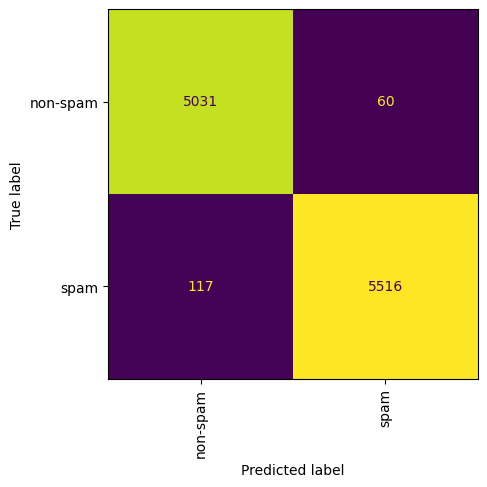

In [21]:
test_pred_clf = clf.predict(test_data['preprocessed_text_combined'])
plot_prediction_results(test_pred_clf, test_data['label'].values)

In [18]:
%%time
from sklearn import svm
svm_clf = make_pipeline(TfidfVectorizer(), svm.LinearSVC())
svm_clf.fit(train_data['preprocessed_text_combined'].values, train_data['label'].values)

CPU times: total: 8.2 s
Wall time: 8.21 s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc', LinearSVC())])

Mean Squared Error :	0.00867
Weighted F1 Score :	0.991
Accuracy Score :	99.133 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

    non-spam       0.99      0.99      0.99      5149
        spam       0.99      0.99      0.99      5575

    accuracy                           0.99     10724
   macro avg       0.99      0.99      0.99     10724
weighted avg       0.99      0.99      0.99     10724

----------------------------------------------------------------------

 Confusion Matrix: 



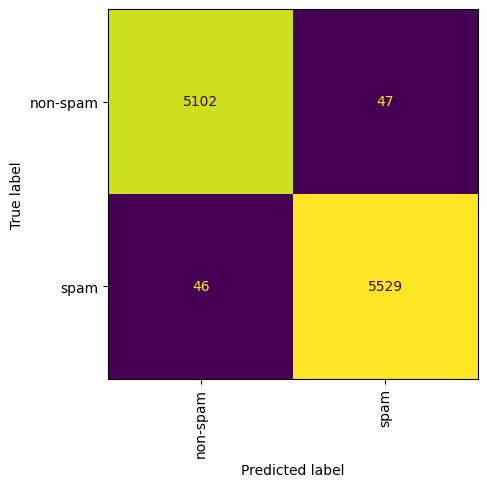

In [23]:
test_pred_clf_svm = svm_clf.predict(test_data['preprocessed_text_combined'])
plot_prediction_results(test_pred_clf_svm, test_data['label'].values)

In [24]:
%%time
from sklearn.naive_bayes import MultinomialNB
nabayes_clf = make_pipeline(TfidfVectorizer(), MultinomialNB())
nabayes_clf.fit(train_data['preprocessed_text_combined'].values, train_data['label'].values)

CPU times: total: 7.66 s
Wall time: 7.66 s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

Mean Squared Error :	0.02574
Weighted F1 Score :	0.974
Accuracy Score :	97.426 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

    non-spam       0.99      0.96      0.97      5312
        spam       0.96      0.99      0.97      5412

    accuracy                           0.97     10724
   macro avg       0.97      0.97      0.97     10724
weighted avg       0.97      0.97      0.97     10724

----------------------------------------------------------------------

 Confusion Matrix: 



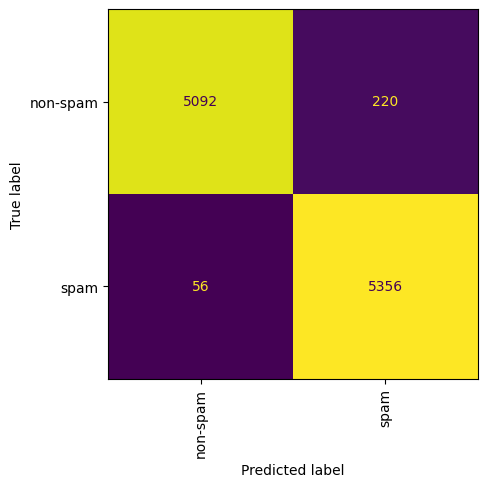

In [25]:
test_pred_clf_nabayes = nabayes_clf.predict(test_data['preprocessed_text_combined'])
plot_prediction_results(test_pred_clf_nabayes, test_data['label'].values)

In [28]:
%%time
from sklearn.tree import DecisionTreeClassifier
dt = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())
dt.fit(train_data['preprocessed_text_combined'].values, train_data['label'].values)

CPU times: total: 1min 36s
Wall time: 1min 36s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

Mean Squared Error :	0.04634
Weighted F1 Score :	0.954
Accuracy Score :	95.366 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

    non-spam       0.95      0.95      0.95      5131
        spam       0.96      0.95      0.96      5593

    accuracy                           0.95     10724
   macro avg       0.95      0.95      0.95     10724
weighted avg       0.95      0.95      0.95     10724

----------------------------------------------------------------------

 Confusion Matrix: 



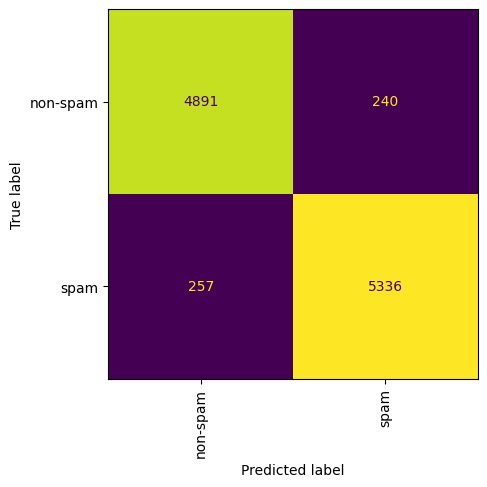

In [29]:
test_pred_clf_dt = dt.predict(test_data['preprocessed_text_combined'])
plot_prediction_results(test_pred_clf_dt, test_data['label'].values)

In [26]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
gbc = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier(random_state=SEED))
gbc.fit(train_data['preprocessed_text_combined'].values, train_data['label'].values)

CPU times: total: 5min 38s
Wall time: 5min 39s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

Mean Squared Error :	0.06658
Weighted F1 Score :	0.934
Accuracy Score :	93.342 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

    non-spam       0.90      0.96      0.93      4846
        spam       0.96      0.91      0.94      5878

    accuracy                           0.93     10724
   macro avg       0.93      0.94      0.93     10724
weighted avg       0.94      0.93      0.93     10724

----------------------------------------------------------------------

 Confusion Matrix: 



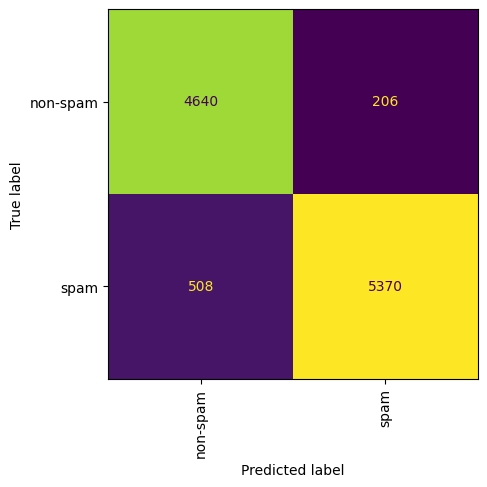

In [27]:
test_pred_clf_gbc = gbc.predict(test_data['preprocessed_text_combined'])
plot_prediction_results(test_pred_clf_gbc, test_data['label'].values)

In [48]:
%%time
from sklearn.neural_network import MLPClassifier
mlp = make_pipeline(TfidfVectorizer(), MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=SEED))
mlp.fit(train_data['preprocessed_text_combined'].values, train_data['label'].values)

CPU times: total: 1min 35s
Wall time: 1min 1s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('mlpclassifier',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15,),
                               random_state=42, solver='lbfgs'))])

Mean Squared Error :	0.01082
Weighted F1 Score :	0.989
Accuracy Score :	98.918 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

    non-spam       0.99      0.99      0.99      5144
        spam       0.99      0.99      0.99      5580

    accuracy                           0.99     10724
   macro avg       0.99      0.99      0.99     10724
weighted avg       0.99      0.99      0.99     10724

----------------------------------------------------------------------

 Confusion Matrix: 



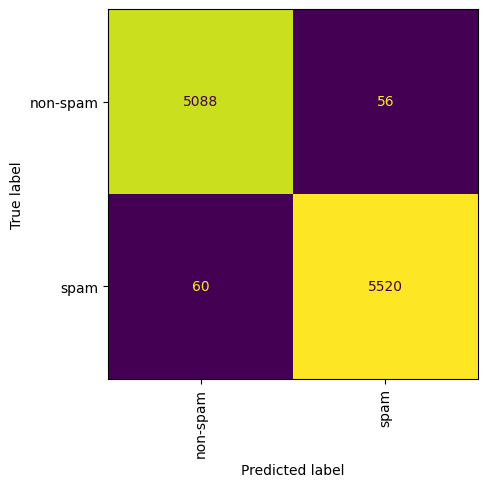

In [49]:
test_pred_clf_mlp = mlp.predict(test_data['preprocessed_text_combined'])
plot_prediction_results(test_pred_clf_mlp, test_data['label'].values)

In [50]:
from sklearn.ensemble import VotingClassifier
vote = VotingClassifier(estimators=[('mlp', mlp), ('svm', svm_clf), ('log_reg', log_reg)], voting='hard')

In [51]:
from sklearn.model_selection import cross_val_score

In [54]:
for clf, label in zip([mlp, svm_clf, log_reg, vote], ['Neural Network', 'C-Support Vector Classification', 'Logistic Regression', 'Ensemble']):
     scores = cross_val_score(clf, train_data['preprocessed_text_combined'].values, train_data['label'].values, scoring='accuracy', cv=5)
     print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.9874 (+/- 0.0007) [Neural Network]
Accuracy: 0.9897 (+/- 0.0006) [C-Support Vector Classification]
Accuracy: 0.9874 (+/- 0.0008) [Logistic Regression]
Accuracy: 0.9889 (+/- 0.0006) [Ensemble]


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, PCA
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [ ]:
%%time
pipe = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("scaling", MaxAbsScaler()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("classify", svm.LinearSVC(dual=False, max_iter=10000)),
    ]
)

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        "reduce_dim": [PCA(iterated_power=7), NMF(max_iter=1_000)],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
]
reducer_labels = ["PCA", "NMF", "KBest(mutual_info_classif)"]

grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
grid.fit(train_data['preprocessed_text_combined'].values, train_data['label'].values)

c:\users\slava\desktop\phishingml\venv\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\users\slava\desktop\phishingml\venv\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\users\slava\desktop\phishingml\venv\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\users\slava\desktop\phishingml\venv\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values f

In [ ]:
test_pred_clf_grid = grid.predict(test_data['preprocessed_text_combined'])
plot_prediction_results(test_pred_clf_grid, test_data['label'].values)